# Region Growing Segmentation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk
from myshow import myshow, myshow3d
import gui

import os

OUTPUT_DIR = "./"

## Read Data and Select Seed Point(s)

In [2]:
T1_WINDOW_LEVEL = (500,50)

input_file_name = "604.000000-COR 3X3-11320_resampled"
img_T1 = sitk.ReadImage("./"+input_file_name+".mha")
img_T1_255 = sitk.Cast(sitk.IntensityWindowing(img_T1, 
                                               windowMinimum=T1_WINDOW_LEVEL[1]-T1_WINDOW_LEVEL[0]/2.0, 
                                               windowMaximum=T1_WINDOW_LEVEL[1]+T1_WINDOW_LEVEL[0]/2.0), 
                       sitk.sitkUInt8)

In [3]:
#%env SITK_SHOW_COMMAND /Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP 
#sitk.Show(img_T1, title="T1")

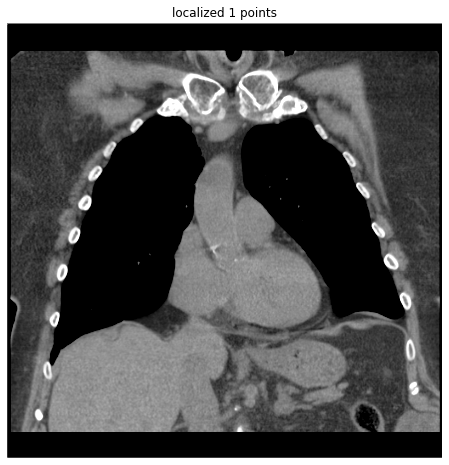

In [4]:
point_acquisition_interface = gui.PointDataAquisition(img_T1, window_level=T1_WINDOW_LEVEL)

#preselected seed point in the left ventricle
idx = img_T1.GetSize()
point_acquisition_interface.set_point_indexes([(int(idx[0]/2), int(idx[1]/2), int(idx[2]-5))])

In [5]:
initial_seed_point_indexes = point_acquisition_interface.get_point_indexes()

## ConnectedThreshold

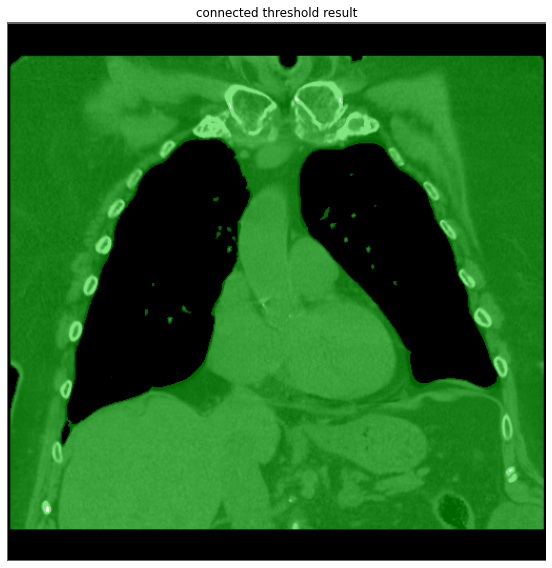

In [6]:
seg_explicit_thresholds = sitk.ConnectedThreshold(img_T1, seedList=initial_seed_point_indexes, lower=-500, upper=1000)
# Overlay the segmentation onto the T1 image
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_T1_255, seg_explicit_thresholds)],                   
                      title_list = ['connected threshold result'])

## ConfidenceConnected

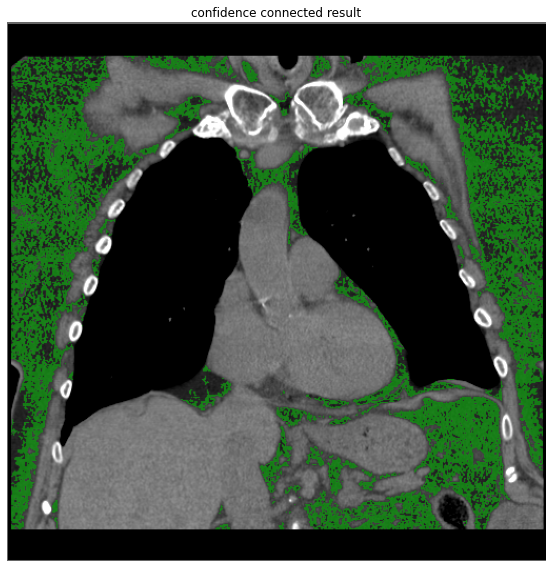

In [7]:
seg_implicit_thresholds = sitk.ConfidenceConnected(img_T1, seedList=initial_seed_point_indexes,
                                                   numberOfIterations=0,
                                                   multiplier=2,
                                                   initialNeighborhoodRadius=1,
                                                   replaceValue=1)

gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_T1_255, seg_implicit_thresholds)],                   
                      title_list = ['confidence connected result'])

## Cleaning

In [8]:
vectorRadius=(3,3,3)
kernel=sitk.sitkBall
seg_implicit_thresholds_clean = sitk.BinaryMorphologicalClosing(seg_explicit_thresholds, 
                                                                vectorRadius,
                                                                kernel)

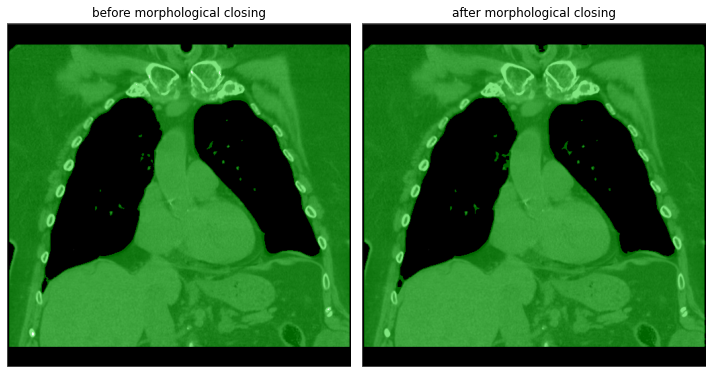

In [9]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_T1_255, seg_explicit_thresholds), 
                                sitk.LabelOverlay(img_T1_255, seg_implicit_thresholds_clean)], 
                  shared_slider=True,
                  title_list = ['before morphological closing', 'after morphological closing'])

## Export Label Image

In [10]:
#sitk.WriteImage(inverted_image, os.path.join(OUTPUT_DIR, "604.000000-COR 3X3-11320_label.mha"))
sitk.WriteImage((seg_implicit_thresholds_clean!=1), os.path.join(OUTPUT_DIR, input_file_name+"_label.mha"))

## Remove Background

In [11]:
img_label = sitk.ReadImage("./"+input_file_name+"_label.mha")

In [41]:
img_label_arr = sitk.GetArrayFromImage(img_label)

for z in range(img_label.GetSize()[2]):
    for y in range(img_label.GetSize()[1]):
        for x in range(-1, img_label.GetSize()[0]-1):
            if x == -1:
                if img_label_arr[z,y,x+1] == 1:
                    img_label_arr[z,y,x+1] = 2
            else:
                if img_label_arr[z,y,x] == 2 and img_label_arr[z,y,x+1] == 1:
                    img_label_arr[z,y,x+1] = 2

for z in range(img_label.GetSize()[2]-1, -1, -1):
    for y in range(img_label.GetSize()[1]-1, -1, -1):
        for x in range(img_label.GetSize()[0]-1, 1, -1):
            if x == img_label.GetSize()[0]-1:
                if img_label_arr[z,y,x-1] == 1:
                    img_label_arr[z,y,x-1] = 2
            else:
                if img_label_arr[z,y,x] == 2 and img_label_arr[z,y,x-1] == 1:
                    img_label_arr[z,y,x-1] = 2

for z in range(img_label.GetSize()[2]):
    for y in range(img_label.GetSize()[1]):
        for x in range(img_label.GetSize()[0]):
            if img_label_arr[z,y,x] == 2:
                img_label_arr[z,y,x] = 0

In [42]:
final_img_label = sitk.GetImageFromArray(img_label_arr)
sitk.WriteImage(final_img_label, os.path.join(OUTPUT_DIR, input_file_name+"_label_final.mha"))